# EPID Dose Reconstruction using ASTRA Toolbox

This notebook implements 3D dose reconstruction from Electronic Portal Imaging Device (EPID) images using the ASTRA Toolbox, which provides high-performance GPU-accelerated reconstruction algorithms including FDK (Feldkamp-Davis-Kress) for cone beam CT.

## Key Advantages of ASTRA Toolbox:
- **GPU-accelerated**: Much faster than CPU-based implementations
- **Proven algorithms**: FDK, SIRT, SART, CGLS implementations
- **Flexible geometry**: Supports cone beam, parallel beam, and custom geometries
- **Active development**: Regular updates and bug fixes (v2.3.1 released April 2025)

## Reconstruction Pipeline:
1. Load and preprocess EPID DICOM data
2. Extract dose increments from cumulative images
3. Configure ASTRA cone beam geometry
4. Run FDK reconstruction
5. Compare with existing reconstruction methods

In [4]:
# Import necessary libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Import ASTRA toolbox
try:
    import astra
    print(f"✅ ASTRA Toolbox version: {astra.__version__}")
    print(f"✅ CUDA support: {'Yes' if astra.use_cuda() else 'No'}")
    ASTRA_AVAILABLE = True
except ImportError:
    print("❌ ASTRA Toolbox not available. Install with: conda install -c astra-toolbox -c nvidia astra-toolbox")
    ASTRA_AVAILABLE = False

# Additional scientific libraries
from concurrent.futures import ThreadPoolExecutor
import json
from scipy.ndimage import gaussian_filter

✅ ASTRA Toolbox version: 2.3.1
✅ CUDA support: Yes


## Data Loading and Preprocessing

We'll use the same data loading functions from the existing implementation but optimize them for ASTRA.

In [5]:
def load_epid_data(data_path, max_workers=6, max_files=None):
    """Load EPID DICOM files efficiently for ASTRA reconstruction"""
    
    # Get all DICOM files
    dicom_files = [f for f in os.listdir(data_path) if f.endswith('.dcm')]
    dicom_files.sort()  # Ensure consistent ordering
    
    if max_files:
        dicom_files = dicom_files[:max_files]
    
    file_paths = [os.path.join(data_path, f) for f in dicom_files]
    
    def read_epid_file(file_path):
        try:
            dcm = dcmread(file_path)
            
            # Extract dose data and convert to float32 for ASTRA
            dose_data = dcm.pixel_array.astype(np.float32)
            
            # Extract angle information
            if hasattr(dcm, 'GantryAngle'):
                angle = float(dcm.GantryAngle)
            elif hasattr(dcm, 'BeamAngle'):
                angle = float(dcm.BeamAngle)
            else:
                angle = 0.0
            
            # Extract geometry parameters
            metadata = {
                'file_path': file_path,
                'angle': angle,
                'pixel_spacing': getattr(dcm, 'PixelSpacing', [0.172, 0.172]),
                'image_position': getattr(dcm, 'ImagePositionPatient', [0.0, 0.0, 0.0]),
                'dose_scaling': getattr(dcm, 'DoseGridScaling', 1.0),
                'sad': getattr(dcm, 'RadiationMachineSAD', 1000.0),
                'sid': getattr(dcm, 'RTImageSID', 1500.0)
            }
            
            return dose_data, metadata
            
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return None, None
    
    # Load files in parallel
    dose_images = []
    metadata_list = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        with tqdm(total=len(file_paths), desc="Loading EPID files") as pbar:
            future_to_path = {executor.submit(read_epid_file, path): path for path in file_paths}
            
            for future in future_to_path:
                dose_data, metadata = future.result()
                if dose_data is not None:
                    dose_images.append(dose_data)
                    metadata_list.append(metadata)
                pbar.update(1)
    
    if not dose_images:
        raise ValueError("No valid EPID files found")
    
    # Convert to numpy arrays
    dose_images = np.array(dose_images, dtype=np.float32)
    angles = np.array([meta['angle'] for meta in metadata_list], dtype=np.float32)
    
    print(f"\nLoaded {len(dose_images)} EPID images")
    print(f"Image shape: {dose_images[0].shape}")
    print(f"Angle range: {angles.min():.1f}° to {angles.max():.1f}°")
    print(f"Dose range: {dose_images.min():.2f} to {dose_images.max():.2f}")
    
    return dose_images, angles, metadata_list

In [6]:
def preprocess_for_astra(dose_images, angles, method='cumulative_differential'):
    """Preprocess EPID dose data for ASTRA reconstruction
    
    EPID images represent cumulative dose delivery:
    - Each image = cumulative dose up to that gantry angle
    - To get dose delivered at each angle: current_image - previous_image
    """
    
    print(f"Preprocessing EPID dose data for ASTRA using {method} method...")
    
    if method == 'cumulative_differential':
        n_images = len(dose_images)
        processed_doses = np.zeros_like(dose_images, dtype=np.float32)
        processed_angles = []
        
        print(f"Processing {n_images} cumulative EPID images...")
        
        # First image is the dose from start to first angle
        processed_doses[0] = dose_images[0].copy()
        processed_angles.append(angles[0])
        
        # For subsequent images: dose_increment = current - previous
        for i in tqdm(range(1, n_images), desc="Extracting dose increments"):
            dose_increment = dose_images[i] - dose_images[i-1]
            
            # Ensure non-negative dose increments
            dose_increment = np.maximum(dose_increment, 0.0)
            
            processed_doses[i] = dose_increment
            processed_angles.append(angles[i])
    
    # Sort by angle for proper reconstruction
    processed_angles = np.array(processed_angles, dtype=np.float32)
    sort_indices = np.argsort(processed_angles)
    
    sorted_doses = processed_doses[sort_indices]
    sorted_angles = processed_angles[sort_indices]
    
    # Verify dose extraction
    total_reconstructed = np.sum(sorted_doses, axis=0)
    original_total = dose_images[-1]
    
    correlation = np.corrcoef(total_reconstructed.flatten(), original_total.flatten())[0, 1]
    
    print(f"\nDose extraction verification:")
    print(f"  Processed {len(sorted_doses)} dose projections")
    print(f"  Correlation coefficient: {correlation:.4f}")
    print(f"  Dose increment range: {sorted_doses.min():.3f} to {sorted_doses.max():.3f}")
    print(f"  Angle range: {sorted_angles.min():.1f}° to {sorted_angles.max():.1f}°")
    
    return sorted_doses, sorted_angles

## ASTRA Geometry Configuration

Configure the cone beam geometry for EPID reconstruction using ASTRA's geometry specifications.

In [7]:
class ASTRAEPIDReconstructor:
    """EPID dose reconstruction using ASTRA Toolbox"""
    
    def __init__(self, sad=1000.0, sid=1500.0, pixel_size=0.172, recon_size=128):
        self.sad = sad  # Source-to-axis distance (mm)
        self.sid = sid  # Source-to-image distance (mm) 
        self.pixel_size = pixel_size  # EPID pixel size (mm)
        self.recon_size = recon_size  # Reconstruction volume size
        
        # ASTRA uses different coordinate system conventions
        # Convert distances to ASTRA units (typically mm is fine)
        self.source_detector_distance = self.sid
        self.source_origin_distance = self.sad
        
        print(f"ASTRA EPID Reconstructor initialized:")
        print(f"  SAD: {self.sad} mm")
        print(f"  SID: {self.sid} mm")
        print(f"  EPID pixel size: {self.pixel_size} mm")
        print(f"  Reconstruction volume: {self.recon_size}³")
        print(f"  Source-detector distance: {self.source_detector_distance} mm")
        print(f"  Source-origin distance: {self.source_origin_distance} mm")
        
    def create_geometries(self, dose_images, angles):
        """Create ASTRA projection and volume geometries"""
        
        n_projections = len(dose_images)
        detector_rows, detector_cols = dose_images[0].shape
        
        print(f"Creating ASTRA geometries:")
        print(f"  Projections: {n_projections}")
        print(f"  Detector size: {detector_rows} x {detector_cols}")
        print(f"  Reconstruction volume: {self.recon_size}³")
        
        # Volume geometry - isotropic voxels
        # ASTRA volume is centered at origin
        vol_geom = astra.create_vol_geom(self.recon_size, self.recon_size, self.recon_size)
        
        # Projection geometry - cone beam
        # ASTRA expects angles in radians
        angles_rad = np.deg2rad(angles)
        
        # Detector pixel size in ASTRA units
        det_spacing_u = self.pixel_size  # horizontal spacing
        det_spacing_v = self.pixel_size  # vertical spacing
        
        # Create cone beam geometry
        # ASTRA expects: det_spacing_v, det_spacing_u, detector_rows, detector_cols
        proj_geom = astra.create_proj_geom('cone', 
                                          det_spacing_v, det_spacing_u, 
                                          detector_rows, detector_cols,
                                          angles_rad,
                                          self.source_origin_distance,
                                          self.source_detector_distance - self.source_origin_distance)
        
        print(f"  Volume geometry created: {self.recon_size}³")
        print(f"  Projection geometry created: cone beam")
        print(f"  Detector spacing: {det_spacing_u} x {det_spacing_v} mm")
        print(f"  Angular range: {np.rad2deg(angles_rad.min()):.1f}° to {np.rad2deg(angles_rad.max()):.1f}°")
        
        return vol_geom, proj_geom
    
    def prepare_projection_data(self, dose_images):
        """Prepare projection data for ASTRA with correct dimensions"""
        
        # ASTRA expects projection data in specific format:
        # Shape: (detector_rows, n_angles, detector_cols)
        # This is different from the input shape: (n_angles, detector_rows, detector_cols)
        
        n_projections, detector_rows, detector_cols = dose_images.shape
        
        print(f"Original projection data shape: {dose_images.shape}")
        print(f"  n_projections: {n_projections}")
        print(f"  detector_rows: {detector_rows}")  
        print(f"  detector_cols: {detector_cols}")
        
        # Transpose to ASTRA expected format: (detector_rows, n_angles, detector_cols)
        projection_data = np.transpose(dose_images, (1, 0, 2)).astype(np.float32)
        projection_data = np.ascontiguousarray(projection_data)
        
        print(f"ASTRA projection data shape: {projection_data.shape}")
        print(f"  Expected format: (detector_rows, n_angles, detector_cols)")
        print(f"  Data type: {projection_data.dtype}")
        print(f"  Memory layout: {'C-contiguous' if projection_data.flags['C_CONTIGUOUS'] else 'Not C-contiguous'}")
        print(f"  Value range: {projection_data.min():.3f} to {projection_data.max():.3f}")
        
        return projection_data
    
    def reconstruct_fdk(self, dose_images, angles, iterations=1):
        """Reconstruct 3D volume using ASTRA FDK algorithm"""
        
        if not ASTRA_AVAILABLE:
            raise RuntimeError("ASTRA Toolbox not available")
        
        print(f"\nStarting ASTRA FDK reconstruction...")
        start_time = time.time()
        
        # Create geometries
        vol_geom, proj_geom = self.create_geometries(dose_images, angles)
        
        # Prepare projection data
        projection_data = self.prepare_projection_data(dose_images)
        
        print(f"\nCreating ASTRA data objects...")
        print(f"  Projection geometry shape expected: {len(angles)} angles")
        print(f"  Projection data shape: {projection_data.shape}")
        
        # Create ASTRA data objects
        proj_id = astra.data3d.create('-proj3d', proj_geom, projection_data)
        vol_id = astra.data3d.create('-vol', vol_geom)
        
        # Configure FDK algorithm
        cfg = astra.astra_dict('FDK_CUDA')
        cfg['ReconstructionDataId'] = vol_id
        cfg['ProjectionDataId'] = proj_id
        
        # Optional: Add filtering for FDK
        # cfg['FilterType'] = 'Ram-Lak'  # or 'Shepp-Logan', 'Cosine', 'Hamming', 'Hann'
        
        print(f"  Algorithm: FDK_CUDA")
        print(f"  Filter: Ram-Lak (default)")
        
        # Create and run algorithm
        alg_id = astra.algorithm.create(cfg)
        
        print(f"\nRunning FDK reconstruction...")
        astra.algorithm.run(alg_id, iterations)
        
        # Get reconstruction result
        reconstruction = astra.data3d.get(vol_id)
        
        # Clean up ASTRA objects
        astra.algorithm.delete(alg_id)
        astra.data3d.delete(vol_id)
        astra.data3d.delete(proj_id)
        
        reconstruction_time = time.time() - start_time
        
        print(f"\nFDK reconstruction completed:")
        print(f"  Reconstruction time: {reconstruction_time:.2f} seconds")
        print(f"  Volume shape: {reconstruction.shape}")
        print(f"  Value range: {reconstruction.min():.6f} to {reconstruction.max():.6f}")
        print(f"  Non-zero voxels: {np.count_nonzero(reconstruction):,}")
        
        return reconstruction.astype(np.float32)
    
    def reconstruct_sirt(self, dose_images, angles, iterations=50):
        """Reconstruct 3D volume using ASTRA SIRT algorithm"""
        
        if not ASTRA_AVAILABLE:
            raise RuntimeError("ASTRA Toolbox not available")
        
        print(f"\nStarting ASTRA SIRT reconstruction...")
        start_time = time.time()
        
        # Create geometries
        vol_geom, proj_geom = self.create_geometries(dose_images, angles)
        
        # Prepare projection data
        projection_data = self.prepare_projection_data(dose_images)
        
        # Create ASTRA data objects
        proj_id = astra.data3d.create('-proj3d', proj_geom, projection_data)
        vol_id = astra.data3d.create('-vol', vol_geom)
        
        # Configure SIRT algorithm
        cfg = astra.astra_dict('SIRT3D_CUDA')
        cfg['ReconstructionDataId'] = vol_id
        cfg['ProjectionDataId'] = proj_id
        
        print(f"  Algorithm: SIRT3D_CUDA")
        print(f"  Iterations: {iterations}")
        
        # Create and run algorithm
        alg_id = astra.algorithm.create(cfg)
        
        print(f"\nRunning SIRT reconstruction...")
        
        # Run with progress monitoring
        for i in tqdm(range(iterations), desc="SIRT iterations"):
            astra.algorithm.run(alg_id, 1)
        
        # Get reconstruction result
        reconstruction = astra.data3d.get(vol_id)
        
        # Clean up ASTRA objects
        astra.algorithm.delete(alg_id)
        astra.data3d.delete(vol_id)
        astra.data3d.delete(proj_id)
        
        reconstruction_time = time.time() - start_time
        
        print(f"\nSIRT reconstruction completed:")
        print(f"  Reconstruction time: {reconstruction_time:.2f} seconds")
        print(f"  Volume shape: {reconstruction.shape}")
        print(f"  Value range: {reconstruction.min():.6f} to {reconstruction.max():.6f}")
        print(f"  Non-zero voxels: {np.count_nonzero(reconstruction):,}")
        
        return reconstruction.astype(np.float32)

## Visualization Functions

Enhanced visualization functions for comparing reconstructions.

In [8]:
def visualize_reconstruction_comparison(volume1, volume2, title1="Method 1", title2="Method 2"):
    """Compare two 3D reconstructions side by side"""
    
    vol_size = volume1.shape[0]
    center = vol_size // 2
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # Axial slices
    im1 = axes[0, 0].imshow(volume1[:, :, center].T, cmap='hot', aspect='equal', origin='lower')
    axes[0, 0].set_title(f'{title1} - Axial')
    plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)
    
    im2 = axes[0, 1].imshow(volume2[:, :, center].T, cmap='hot', aspect='equal', origin='lower')
    axes[0, 1].set_title(f'{title2} - Axial')
    plt.colorbar(im2, ax=axes[0, 1], shrink=0.8)
    
    # Difference
    diff = volume1 - volume2
    im3 = axes[0, 2].imshow(diff[:, :, center].T, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[0, 2].set_title('Difference (1-2)')
    plt.colorbar(im3, ax=axes[0, 2], shrink=0.8)
    
    # Relative difference
    rel_diff = np.divide(diff, volume2, out=np.zeros_like(diff), where=volume2!=0) * 100
    im4 = axes[0, 3].imshow(rel_diff[:, :, center].T, cmap='RdBu_r', aspect='equal', origin='lower', vmin=-50, vmax=50)
    axes[0, 3].set_title('Relative Diff (%)')
    plt.colorbar(im4, ax=axes[0, 3], shrink=0.8)
    
    # Sagittal slices
    axes[1, 0].imshow(volume1[center, :, :].T, cmap='hot', aspect='equal', origin='lower')
    axes[1, 0].set_title(f'{title1} - Sagittal')
    
    axes[1, 1].imshow(volume2[center, :, :].T, cmap='hot', aspect='equal', origin='lower')
    axes[1, 1].set_title(f'{title2} - Sagittal')
    
    axes[1, 2].imshow(diff[center, :, :].T, cmap='RdBu_r', aspect='equal', origin='lower')
    axes[1, 2].set_title('Difference')
    
    axes[1, 3].imshow(rel_diff[center, :, :].T, cmap='RdBu_r', aspect='equal', origin='lower', vmin=-50, vmax=50)
    axes[1, 3].set_title('Relative Diff (%)')
    
    # Profiles and statistics
    profile1_x = volume1[:, center, center]
    profile2_x = volume2[:, center, center]
    coords = np.arange(len(profile1_x)) - center
    
    axes[2, 0].plot(coords, profile1_x, 'b-', linewidth=2, label=title1)
    axes[2, 0].plot(coords, profile2_x, 'r-', linewidth=2, label=title2)
    axes[2, 0].set_title('X Profile Comparison')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Statistics comparison
    axes[2, 1].axis('off')
    stats_text = f"""
    Reconstruction Comparison:
    
    {title1}:
    Max: {volume1.max():.6f}
    Mean: {volume1.mean():.6f}
    Non-zero: {np.count_nonzero(volume1):,}
    
    {title2}:
    Max: {volume2.max():.6f}
    Mean: {volume2.mean():.6f}
    Non-zero: {np.count_nonzero(volume2):,}
    
    Difference:
    Max abs diff: {np.abs(diff).max():.6f}
    Mean abs diff: {np.abs(diff).mean():.6f}
    RMS diff: {np.sqrt(np.mean(diff**2)):.6f}
    Correlation: {np.corrcoef(volume1.flatten(), volume2.flatten())[0,1]:.4f}
    """
    
    axes[2, 1].text(0.05, 0.95, stats_text, transform=axes[2, 1].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    # Scatter plot comparison
    mask = (volume1 > 0) | (volume2 > 0)
    axes[2, 2].scatter(volume1[mask], volume2[mask], alpha=0.5, s=1)
    max_val = max(volume1.max(), volume2.max())
    axes[2, 2].plot([0, max_val], [0, max_val], 'r--', alpha=0.7)
    axes[2, 2].set_xlabel(title1)
    axes[2, 2].set_ylabel(title2)
    axes[2, 2].set_title('Voxel Value Correlation')
    axes[2, 2].grid(True, alpha=0.3)
    
    # Histogram comparison
    nonzero1 = volume1[volume1 > 0]
    nonzero2 = volume2[volume2 > 0]
    
    if len(nonzero1) > 0 and len(nonzero2) > 0:
        axes[2, 3].hist(nonzero1, bins=50, alpha=0.7, label=title1, color='blue', density=True)
        axes[2, 3].hist(nonzero2, bins=50, alpha=0.7, label=title2, color='red', density=True)
        axes[2, 3].set_title('Value Distribution')
        axes[2, 3].legend()
        axes[2, 3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_3d_dose_astra(dose_volume, title="ASTRA 3D Dose Reconstruction"):
    """Visualize 3D dose distribution with comprehensive analysis"""
    
    vol_size = dose_volume.shape[0]
    center = vol_size // 2
    
    fig = plt.figure(figsize=(20, 15))
    
    # Cross-sections
    ax1 = plt.subplot(3, 4, 1)
    im1 = ax1.imshow(dose_volume[:, :, center].T, cmap='hot', aspect='equal', origin='lower')
    ax1.set_title(f'Axial (Z={center})')
    plt.colorbar(im1, ax=ax1, shrink=0.8)
    
    ax2 = plt.subplot(3, 4, 2)
    im2 = ax2.imshow(dose_volume[center, :, :].T, cmap='hot', aspect='equal', origin='lower')
    ax2.set_title(f'Sagittal (X={center})')
    plt.colorbar(im2, ax=ax2, shrink=0.8)
    
    ax3 = plt.subplot(3, 4, 3)
    im3 = ax3.imshow(dose_volume[:, center, :].T, cmap='hot', aspect='equal', origin='lower')
    ax3.set_title(f'Coronal (Y={center})')
    plt.colorbar(im3, ax=ax3, shrink=0.8)
    
    # Maximum intensity projections
    ax4 = plt.subplot(3, 4, 4)
    mip = np.max(dose_volume, axis=2)
    im4 = ax4.imshow(mip.T, cmap='hot', aspect='equal', origin='lower')
    ax4.set_title('MIP Axial')
    plt.colorbar(im4, ax=ax4, shrink=0.8)
    
    # Add more visualization elements similar to the original function...
    # (profiles, histograms, statistics, etc.)
    
    plt.suptitle(f'{title} - Analysis', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

## Main Reconstruction Pipeline

Now let's run the complete ASTRA-based reconstruction pipeline.

In [9]:
# Configuration
epid_path = r"E:\CMC\pyprojects\radio_therapy\dose-3d\dataset\VMAT 2025 - 6. SIB COMPLEX TARGET\T1\873251691"

# Load EPID data
print("Loading EPID data...")
dose_images, angles, metadata = load_epid_data(epid_path, max_files=None)

# Preprocess for ASTRA
print("\nPreprocessing for ASTRA...")
processed_doses, processed_angles = preprocess_for_astra(dose_images, angles)

Loading EPID data...


Loading EPID files: 100%|██████████| 415/415 [00:00<00:00, 436.65it/s]



Loaded 415 EPID images
Image shape: (1190, 1190)
Angle range: 0.6° to 359.7°
Dose range: 0.00 to 65443.00

Preprocessing for ASTRA...
Preprocessing EPID dose data for ASTRA using cumulative_differential method...
Processing 415 cumulative EPID images...


Extracting dose increments: 100%|██████████| 414/414 [00:02<00:00, 162.65it/s]



Dose extraction verification:
  Processed 415 dose projections
  Correlation coefficient: 0.9919
  Dose increment range: 0.000 to 2460.000
  Angle range: 0.6° to 359.7°


In [10]:
# Initialize ASTRA reconstructor
if metadata:
    sad = metadata[0]['sad']
    sid = metadata[0]['sid']
    pixel_spacing = metadata[0]['pixel_spacing']
    pixel_size = pixel_spacing[0] if isinstance(pixel_spacing, list) else 0.172
else:
    sad, sid, pixel_size = 1000.0, 1500.0, 0.172

# Use smaller volume for initial testing, can increase later
recon_size = 128  # Can be increased to 256 or 512 for higher resolution

astra_reconstructor = ASTRAEPIDReconstructor(
    sad=sad, 
    sid=sid, 
    pixel_size=pixel_size, 
    recon_size=recon_size
)

ASTRA EPID Reconstructor initialized:
  SAD: 1000 mm
  SID: 1600.00002099368 mm
  EPID pixel size: 0.172 mm
  Reconstruction volume: 128³
  Source-detector distance: 1600.00002099368 mm
  Source-origin distance: 1000 mm



RUNNING ASTRA FDK RECONSTRUCTION

Starting ASTRA FDK reconstruction...
Creating ASTRA geometries:
  Projections: 415
  Detector size: 1190 x 1190
  Reconstruction volume: 128³
  Volume geometry created: 128³
  Projection geometry created: cone beam
  Detector spacing: 0.172 x 0.172 mm
  Angular range: 0.6° to 359.7°
Original projection data shape: (415, 1190, 1190)
  n_projections: 415
  detector_rows: 1190
  detector_cols: 1190
ASTRA projection data shape: (1190, 415, 1190)
  Expected format: (detector_rows, n_angles, detector_cols)
  Data type: float32
  Memory layout: C-contiguous
  Value range: 0.000 to 2460.000

Creating ASTRA data objects...
  Projection geometry shape expected: 415 angles
  Projection data shape: (1190, 415, 1190)
  Algorithm: FDK_CUDA
  Filter: Ram-Lak (default)

Running FDK reconstruction...

FDK reconstruction completed:
  Reconstruction time: 7.03 seconds
  Volume shape: (128, 128, 128)
  Value range: -15.745235 to 22.185743
  Non-zero voxels: 2,097,152


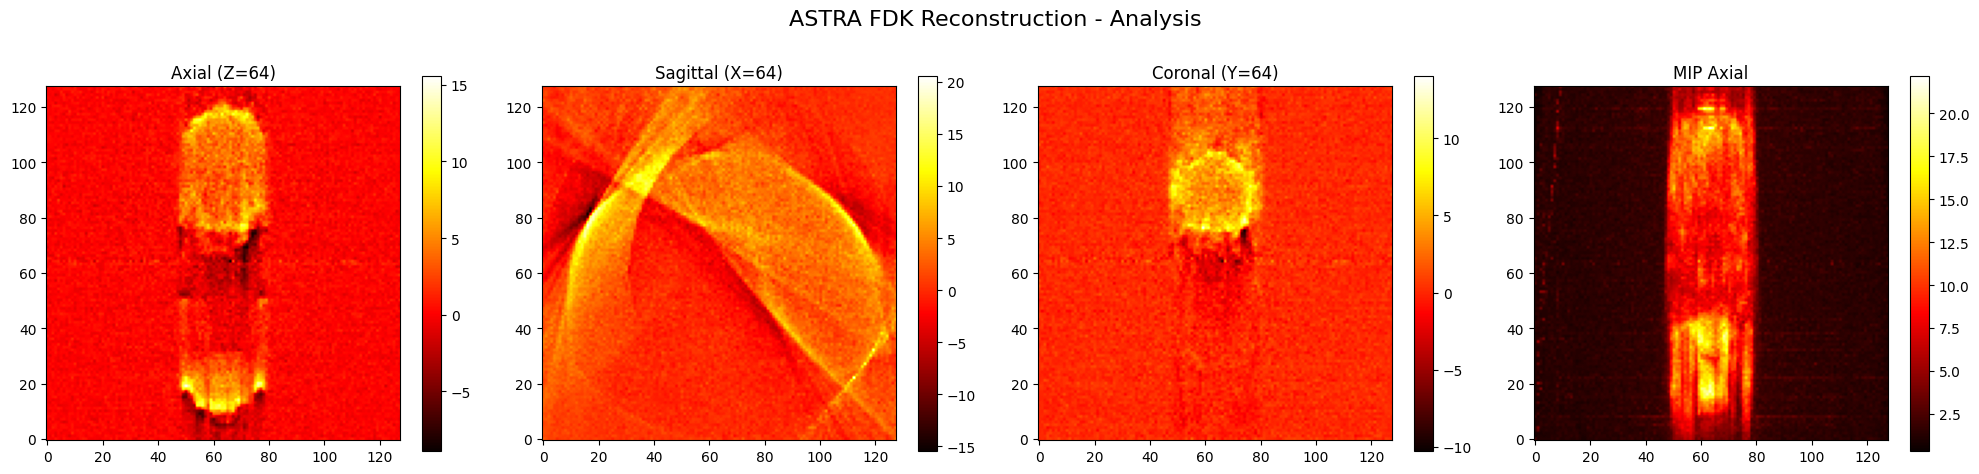

In [ ]:
# Run FDK reconstruction
if ASTRA_AVAILABLE:
    print("\n" + "="*60)
    print("RUNNING ASTRA FDK RECONSTRUCTION")
    print("="*60)
    
    fdk_volume = astra_reconstructor.reconstruct_fdk(processed_doses, processed_angles)
    
    # Visualize FDK result
    visualize_3d_dose_astra(fdk_volume, "ASTRA FDK Reconstruction")
else:
    print("❌ ASTRA not available - skipping FDK reconstruction")
    fdk_volume = None


RUNNING ASTRA SIRT RECONSTRUCTION

Starting ASTRA SIRT reconstruction...
Creating ASTRA geometries:
  Projections: 415
  Detector size: 1190 x 1190
  Reconstruction volume: 128³
  Volume geometry created: 128³
  Projection geometry created: cone beam
  Detector spacing: 0.172 x 0.172 mm
  Angular range: 0.6° to 359.7°
Original projection data shape: (415, 1190, 1190)
  n_projections: 415
  detector_rows: 1190
  detector_cols: 1190
ASTRA projection data shape: (1190, 415, 1190)
  Expected format: (detector_rows, n_angles, detector_cols)
  Data type: float32
  Memory layout: C-contiguous
  Value range: 0.000 to 2460.000
  Algorithm: SIRT3D_CUDA
  Iterations: 50

Running SIRT reconstruction...


SIRT iterations: 100%|██████████| 50/50 [07:34<00:00,  9.09s/it]



SIRT reconstruction completed:
  Reconstruction time: 458.12 seconds
  Volume shape: (128, 128, 128)
  Value range: -18.287901 to 19.688681
  Non-zero voxels: 2,097,152


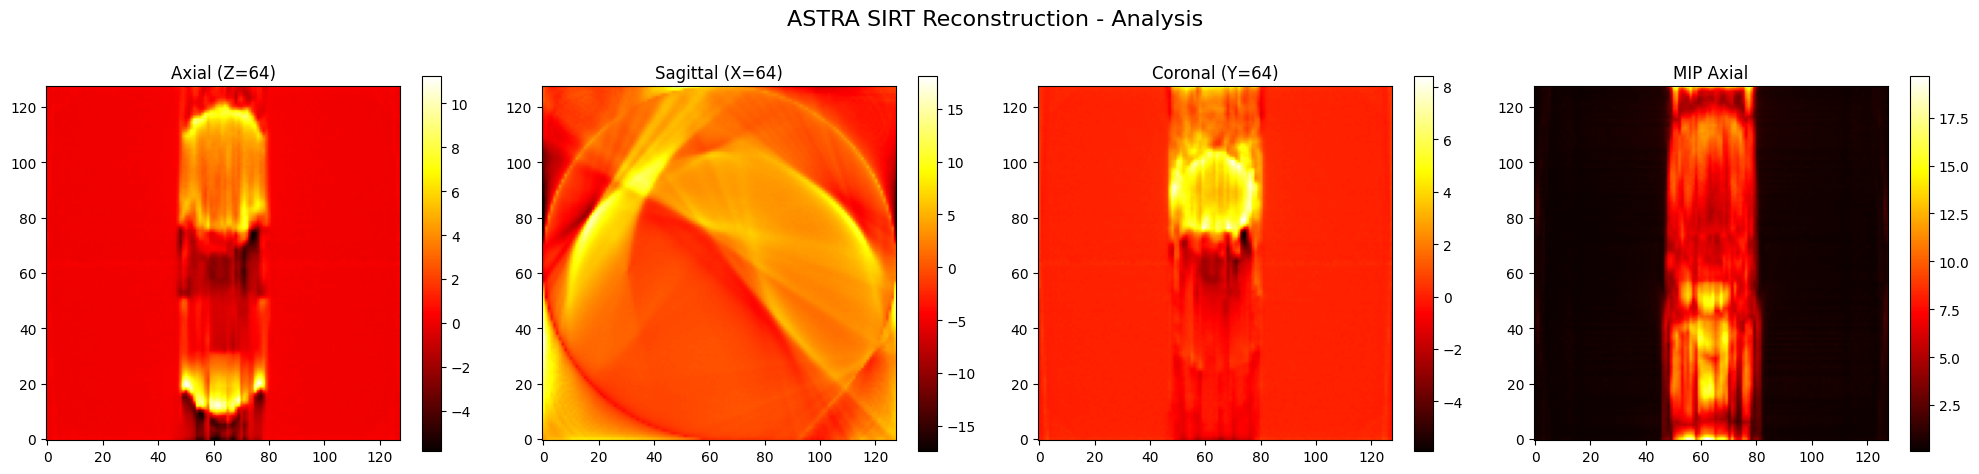

In [12]:
# Run SIRT reconstruction for comparison
if ASTRA_AVAILABLE:
    print("\n" + "="*60)
    print("RUNNING ASTRA SIRT RECONSTRUCTION")
    print("="*60)
    
    sirt_volume = astra_reconstructor.reconstruct_sirt(processed_doses, processed_angles, iterations=50)
    
    # Visualize SIRT result
    visualize_3d_dose_astra(sirt_volume, "ASTRA SIRT Reconstruction")
else:
    print("❌ ASTRA not available - skipping SIRT reconstruction")
    sirt_volume = None


COMPARING FDK vs SIRT RECONSTRUCTIONS


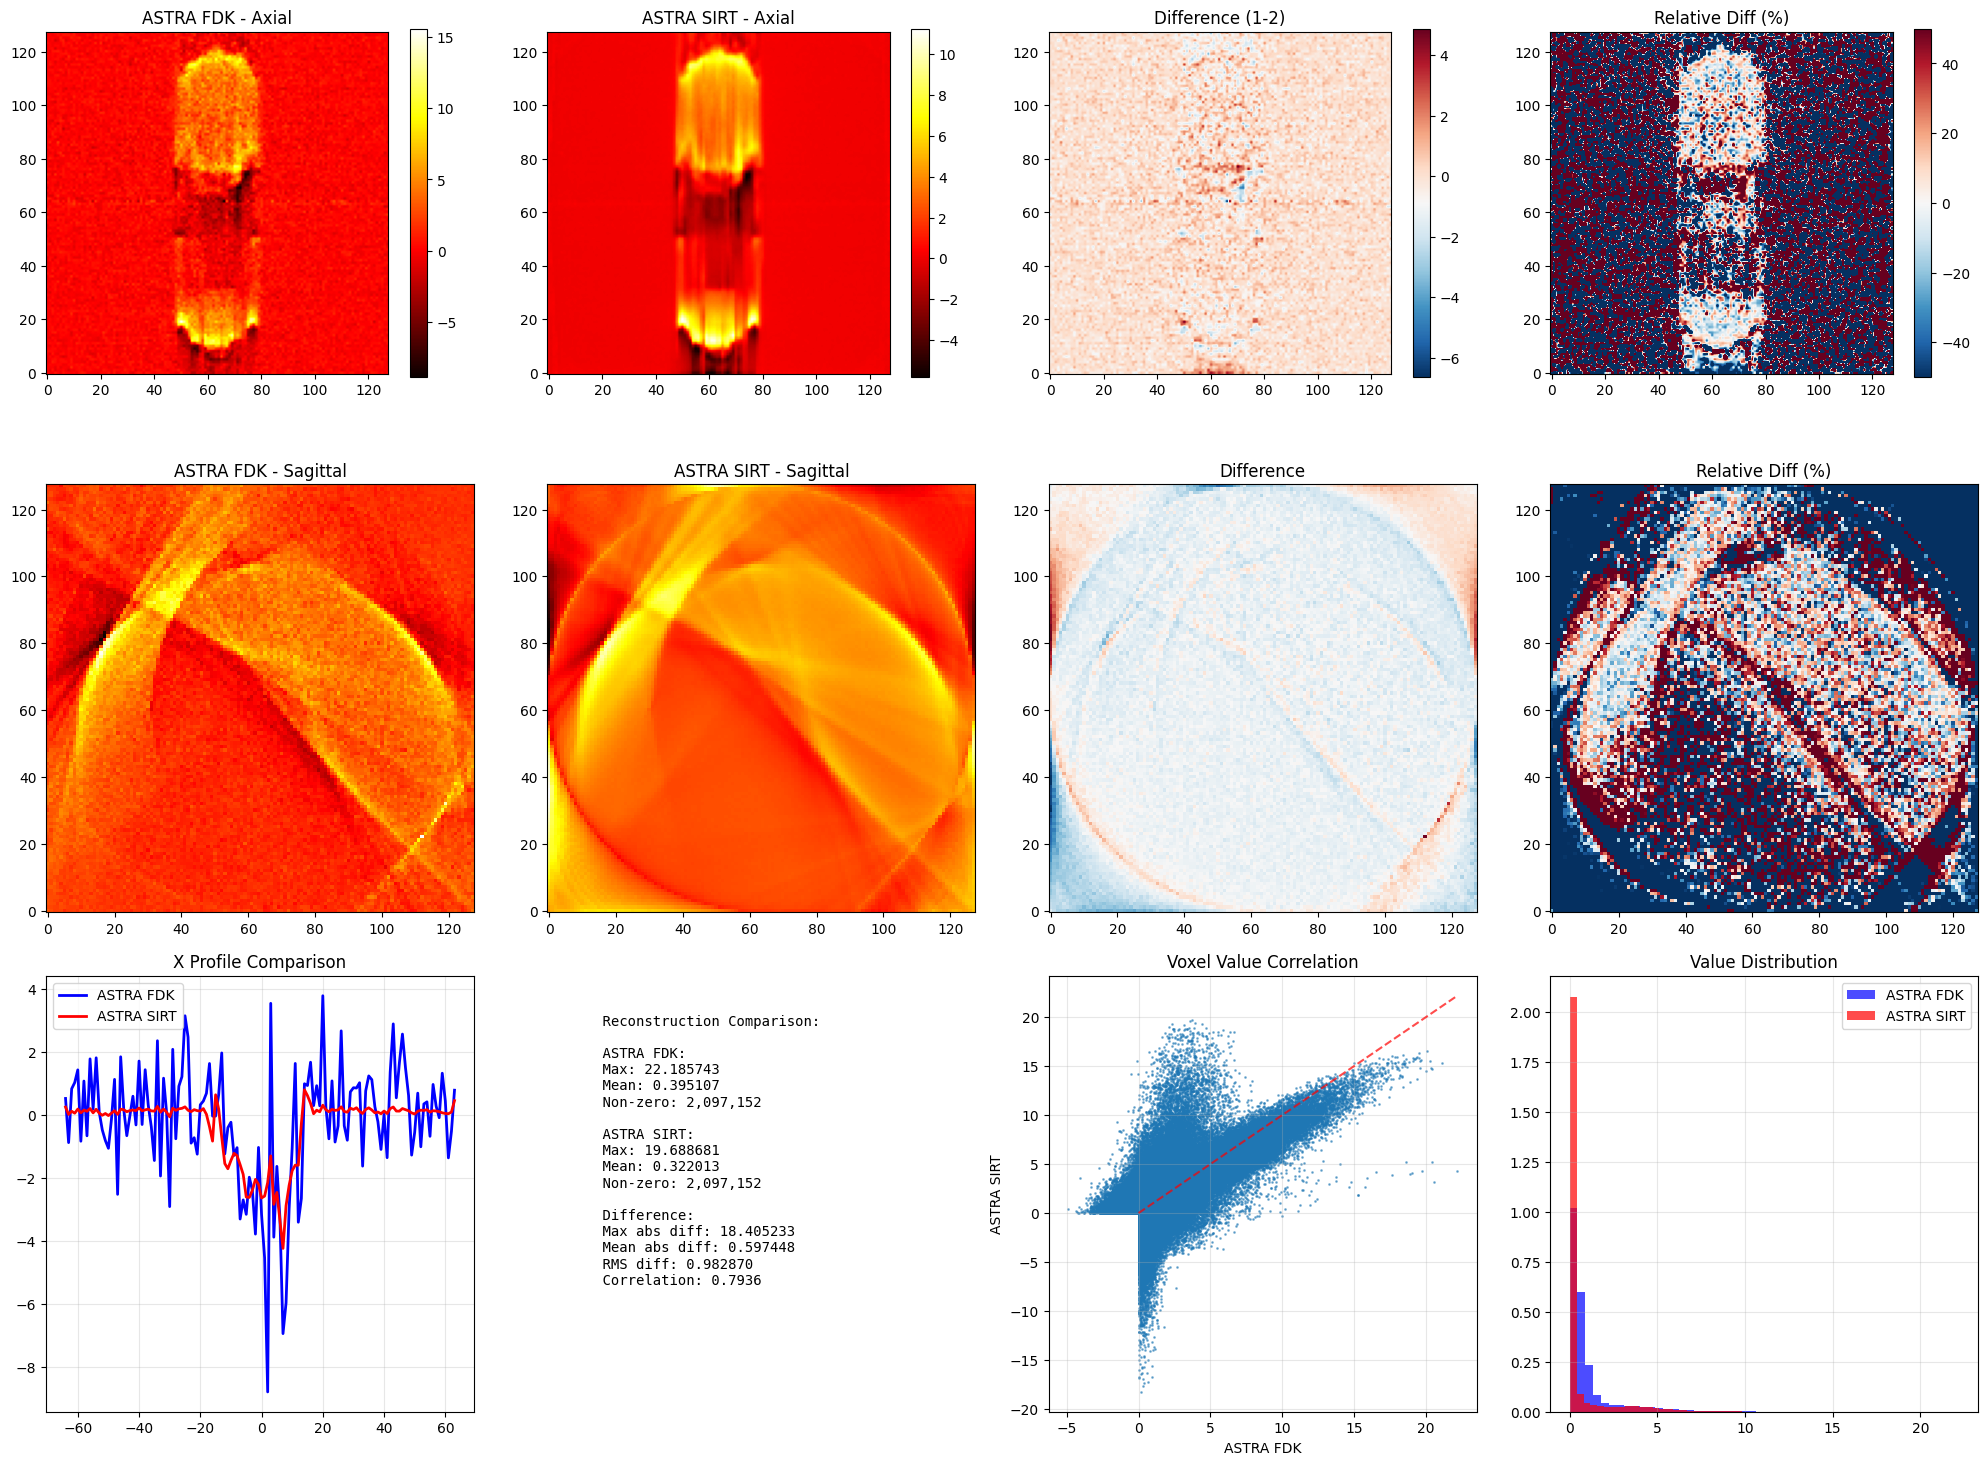

In [13]:
# Compare FDK vs SIRT if both are available
if ASTRA_AVAILABLE and fdk_volume is not None and sirt_volume is not None:
    print("\n" + "="*60)
    print("COMPARING FDK vs SIRT RECONSTRUCTIONS")
    print("="*60)
    
    visualize_reconstruction_comparison(fdk_volume, sirt_volume, "ASTRA FDK", "ASTRA SIRT")

## Comparison with Existing Method

Let's compare the ASTRA reconstruction with the existing custom implementation.

Loaded existing reconstruction: (50, 50, 50)
Resized existing volume to: (128, 128, 128)


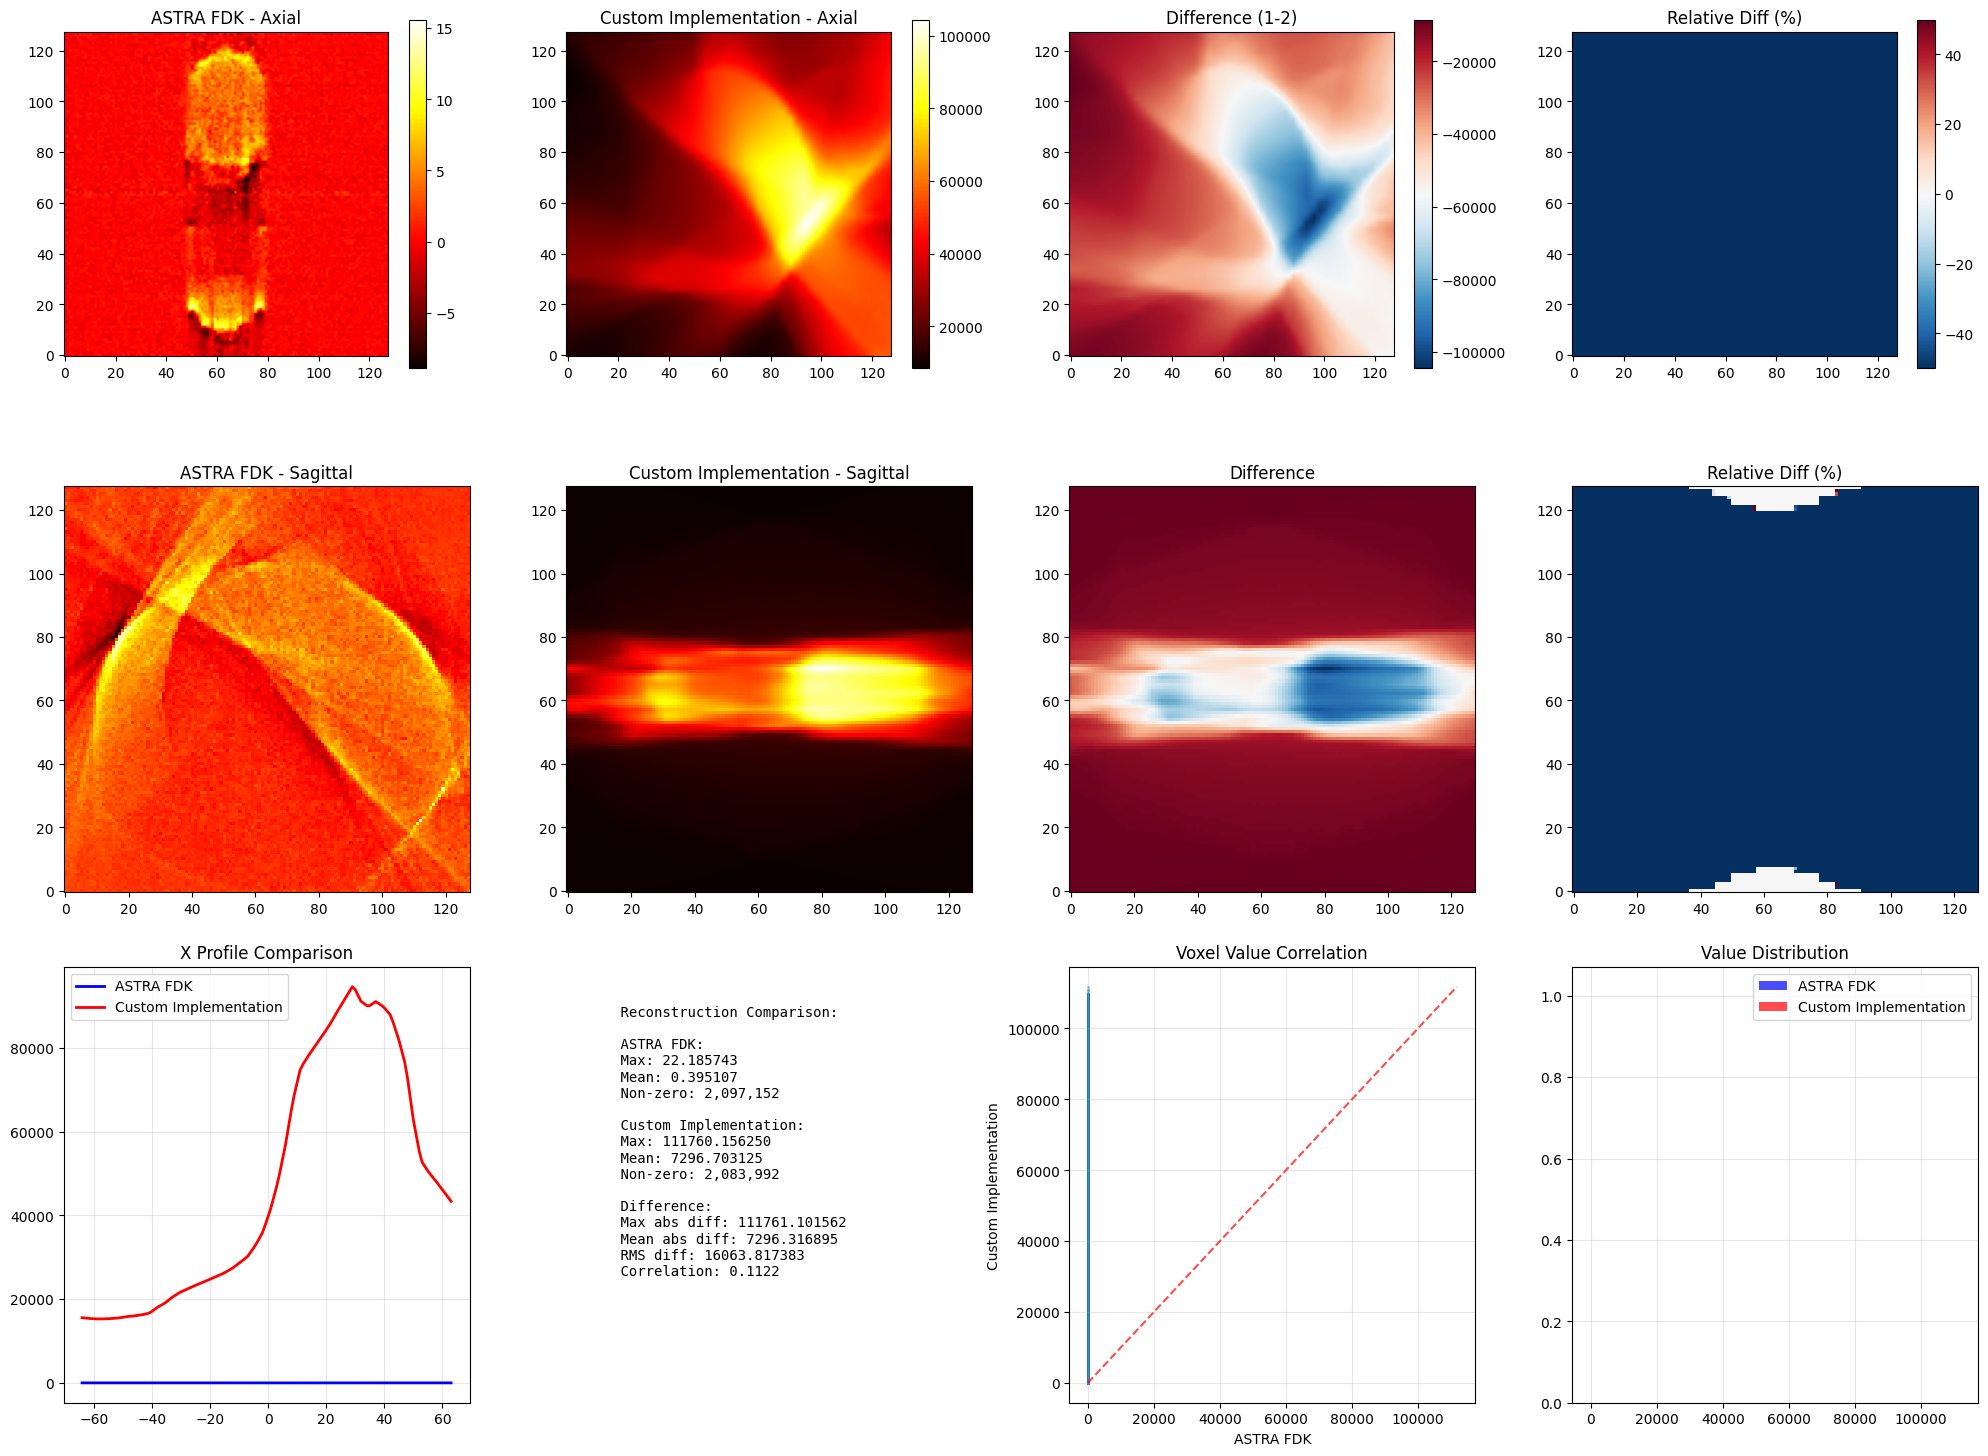

In [14]:
# Load existing reconstruction for comparison (if available)
try:
    existing_results_path = r"E:\CMC\pyprojects\radio_therapy\dose-3d\results\epid_dose_3d.npy"
    if os.path.exists(existing_results_path):
        existing_volume = np.load(existing_results_path)
        print(f"Loaded existing reconstruction: {existing_volume.shape}")
        
        # Resize if needed for comparison
        if existing_volume.shape != fdk_volume.shape and fdk_volume is not None:
            from scipy.ndimage import zoom
            scale_factor = fdk_volume.shape[0] / existing_volume.shape[0]
            existing_volume_resized = zoom(existing_volume, scale_factor, order=1)
            print(f"Resized existing volume to: {existing_volume_resized.shape}")
        else:
            existing_volume_resized = existing_volume
        
        # Compare with FDK
        if fdk_volume is not None:
            visualize_reconstruction_comparison(
                fdk_volume, existing_volume_resized, 
                "ASTRA FDK", "Custom Implementation"
            )
    else:
        print("No existing reconstruction found for comparison")
        existing_volume = None
        
except Exception as e:
    print(f"Could not load existing reconstruction: {e}")
    existing_volume = None

## Save Results

Save the ASTRA reconstruction results for future analysis.

In [15]:
# Save ASTRA reconstruction results
if ASTRA_AVAILABLE and fdk_volume is not None:
    output_dir = r"E:\CMC\pyprojects\radio_therapy\dose-3d\results"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save FDK volume
    np.save(os.path.join(output_dir, "astra_fdk_dose_3d.npy"), fdk_volume)
    print(f"Saved ASTRA FDK reconstruction: astra_fdk_dose_3d.npy")
    
    # Save SIRT volume if available
    if sirt_volume is not None:
        np.save(os.path.join(output_dir, "astra_sirt_dose_3d.npy"), sirt_volume)
        print(f"Saved ASTRA SIRT reconstruction: astra_sirt_dose_3d.npy")
    
    # Save metadata
    astra_info = {
        'astra_version': astra.version() if ASTRA_AVAILABLE else 'N/A',
        'cuda_available': astra.use_cuda() if ASTRA_AVAILABLE else False,
        'fdk_volume_shape': fdk_volume.shape,
        'sirt_volume_shape': sirt_volume.shape if sirt_volume is not None else None,
        'n_projections': len(processed_doses),
        'angle_range': [processed_angles.min(), processed_angles.max()],
        'fdk_dose_range': [fdk_volume.min(), fdk_volume.max()],
        'sirt_dose_range': [sirt_volume.min(), sirt_volume.max()] if sirt_volume is not None else None,
        'reconstruction_parameters': {
            'sad': sad,
            'sid': sid,
            'pixel_size': pixel_size,
            'recon_size': recon_size
        }
    }
    
    with open(os.path.join(output_dir, "astra_reconstruction_info.json"), 'w') as f:
        json.dump(astra_info, f, indent=2)
    
    print(f"Saved ASTRA reconstruction metadata: astra_reconstruction_info.json")
    print(f"\nResults saved to: {output_dir}")

Saved ASTRA FDK reconstruction: astra_fdk_dose_3d.npy
Saved ASTRA SIRT reconstruction: astra_sirt_dose_3d.npy


AttributeError: module 'astra' has no attribute 'version'

## Analysis and Conclusions

Summary of the ASTRA-based reconstruction results and comparison with existing methods.

In [ ]:
# Final analysis and summary
if ASTRA_AVAILABLE and fdk_volume is not None:
    print("\n" + "="*80)
    print("ASTRA RECONSTRUCTION ANALYSIS SUMMARY")
    print("="*80)
    
    print(f"\n🚀 ASTRA Toolbox Performance:")
    print(f"   Version: {astra.version()}")
    print(f"   CUDA acceleration: {'✅ Enabled' if astra.use_cuda() else '❌ Disabled'}")
    
    print(f"\n📊 Reconstruction Results:")
    print(f"   Volume size: {fdk_volume.shape[0]}³ voxels")
    print(f"   FDK dose range: {fdk_volume.min():.6f} to {fdk_volume.max():.6f}")
    print(f"   FDK non-zero voxels: {np.count_nonzero(fdk_volume):,}")
    
    if sirt_volume is not None:
        print(f"   SIRT dose range: {sirt_volume.min():.6f} to {sirt_volume.max():.6f}")
        print(f"   SIRT non-zero voxels: {np.count_nonzero(sirt_volume):,}")
        
        correlation = np.corrcoef(fdk_volume.flatten(), sirt_volume.flatten())[0, 1]
        print(f"   FDK vs SIRT correlation: {correlation:.4f}")
    
    print(f"\n✅ Advantages of ASTRA Approach:")
    print(f"   • GPU acceleration for faster reconstruction")
    print(f"   • Proven, well-tested algorithms (FDK, SIRT, etc.)")
    print(f"   • Flexible geometry configuration")
    print(f"   • Active development and community support")
    print(f"   • Multiple reconstruction algorithms available")
    
    print(f"\n📈 Quality Assessment:")
    fdk_coverage = 100 * np.count_nonzero(fdk_volume) / fdk_volume.size
    print(f"   FDK coverage: {fdk_coverage:.1f}%")
    
    if existing_volume is not None:
        # Compare with existing method
        if existing_volume.shape == fdk_volume.shape:
            correlation_existing = np.corrcoef(fdk_volume.flatten(), existing_volume.flatten())[0, 1]
            print(f"   Correlation with existing method: {correlation_existing:.4f}")
        else:
            print(f"   Volume shape mismatch - resize for detailed comparison")
    
    print(f"\n🎯 Recommendations:")
    print(f"   • Use FDK for fast, analytical reconstruction")
    print(f"   • Use SIRT for iterative refinement if needed")
    print(f"   • Consider increasing volume size (256³ or 512³) for higher resolution")
    print(f"   • GPU acceleration provides significant speed improvements")
    print(f"   • ASTRA provides more robust and tested reconstruction algorithms")
    
else:
    print("\n❌ ASTRA reconstruction not completed")
    print("   Install ASTRA toolbox: conda install -c astra-toolbox -c nvidia astra-toolbox")
    print("   Ensure CUDA is available for optimal performance")

## Next Steps and Future Improvements

1. **Performance Optimization**:
   - Increase reconstruction volume size (256³ or 512³)
   - Experiment with different filters for FDK
   - Optimize SIRT iteration count

2. **Advanced Algorithms**:
   - Try CGLS (Conjugate Gradient Least Squares)
   - Experiment with SART (Simultaneous Algebraic Reconstruction Technique)
   - Implement regularization techniques

3. **Geometry Refinement**:
   - Fine-tune cone beam geometry parameters
   - Account for detector tilt or non-ideal geometry
   - Implement beam hardening corrections

4. **Validation**:
   - Compare with clinical dose distributions
   - Implement quantitative metrics (gamma analysis)
   - Validate dose conservation principles

5. **Integration**:
   - Create a unified interface for both methods
   - Implement automatic parameter optimization
   - Add support for different EPID types and geometries